In [37]:
# Imports
import importlib
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sys.path.append('../_shared_packages')
import process_cl2_logfile as process_cl2#This underline is unavoidable
importlib.reload(process_cl2)

# Load the file... (path,exp_name,ftir_path)
info = (('data/01-16_Cl_baseCaseBAD_noNaOH.csv','01-16-25 Base Case BAD','data/01-16_ftir.prn'),
        ('data/01-16_Cl_baseCase_noNaOH.csv','01-16-25 Base Case','data/01-16_ftir.prn'),
        ('data/01-30-25_rad_count_1_2_part1.csv','01-30-25 Radical Count 1-2ppm P1','data/01-30-25_ftir.prn'),
        ('data/01-30-25_rad_count_1_2_part2.csv','01-30-25 Radical Count 1-2ppm P2','data/01-30-25_ftir.prn'),
        ('data/01-31-25_realistic_AMR.csv','01-31-25 Realistic AMR','data/01-31-25_ftir.prn'),
        ('data/02-07-25_H2S.csv','02-07-25 H2S Sweep','data/02-07-25_ftir.prn'),
        ('data/02-10-25_barn.csv','02-10-25 Realistic Barn','data/02-10-25_ftir.prn'),
        ('data/02-11-25_wwtp_logfile_1.csv','02-11-25 Realistic WWTP','data/02-11-25_ftir.prn'),
        ('data/02-11-25_wwtp_logfile_2.csv','02-11-25 300ppm Radical Count','data/02-11-25_ftir.prn'),
        )
hush=True
raw_data = process_cl2.extract_data([i[:2] for i in info],hush)

# Rebind the ftir
ftir_fields_to_rebind = (('CH4 (PF) 191c average','FTIR: CH4 (ppm)'),('CO2 ppm 191c average','FTIR: CO2 (ppm)'),
                         ('CO ppm 191C (1of2) average','FTIR: CO (ppm)'),('Formaldehyde 191c average','FTIR: CH2O (ppm)'),)
for i in info:
    (path,exp_name,ftir_path)=i
    if ftir_path is not None:
        process_cl2.rebind_ftir_prn(raw_data[exp_name],ftir_path,ftir_fields_to_rebind,hush)

for df in raw_data.values():
    try:
        df['FTIR: CH2O (ppm)']-=0.3 #One can see on inspection that the 'baseline' CH2O value is -0.5, not 0, for some reason. We correct that.
        df['FTIR: CO2 (ppm)']-=1.5 #One can see on inspection that the 'baseline' CO2 value is 1.5, not 0, for some reason. We correct that.
    except: #FTIR widget not used, or said 'no reading' the whole time.
        pass

# Suppress a printout
pass

<h1> Loading, trimming, and re-binding log files </h1>

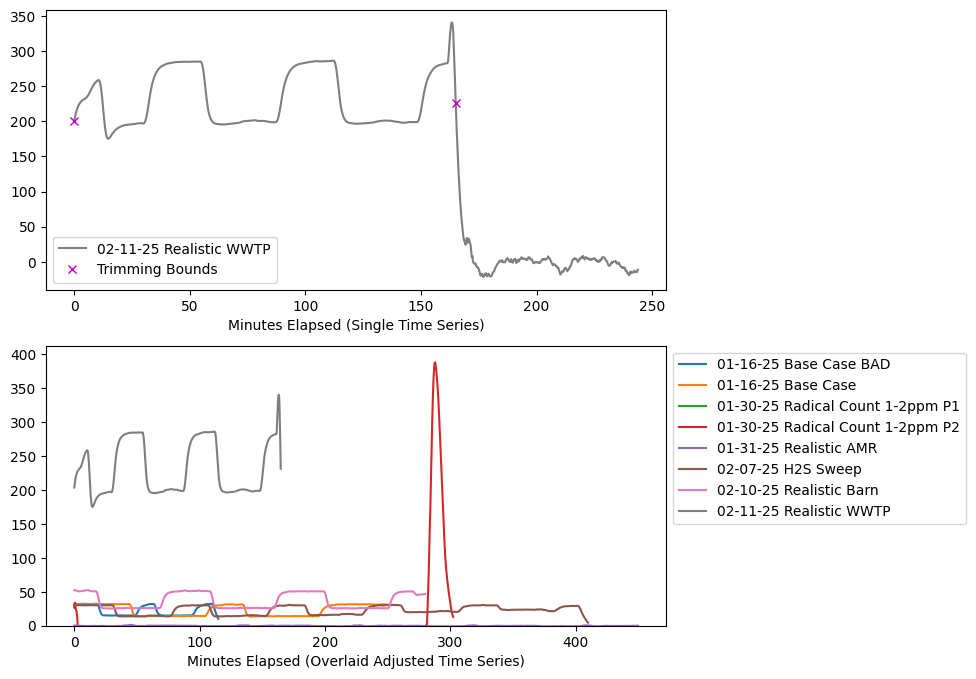

In [41]:
importlib.reload(process_cl2)
trim_params=((135,250),
             (50,300),
             (50,400),
             (50,400),
             (350,800),
             (30,440),
             (80,360),
             (0,165),
             (45,150),
             )
(data,ax1,ax2) = process_cl2.trim_dataframes(raw_data,trim_params,
                                plot=True,which_field='FTIR: CH4 (ppm)',
                                #plot=True,which_field='Cl2 LabJack: Cl2 Node A (mV)',
                                which_df=7)
rf = process_cl2.RemovalFinder(data,"01-06_cl2_final_trials")
ax2.set_ylim(bottom=0)
pass

<h1> Autofind removals </h1>

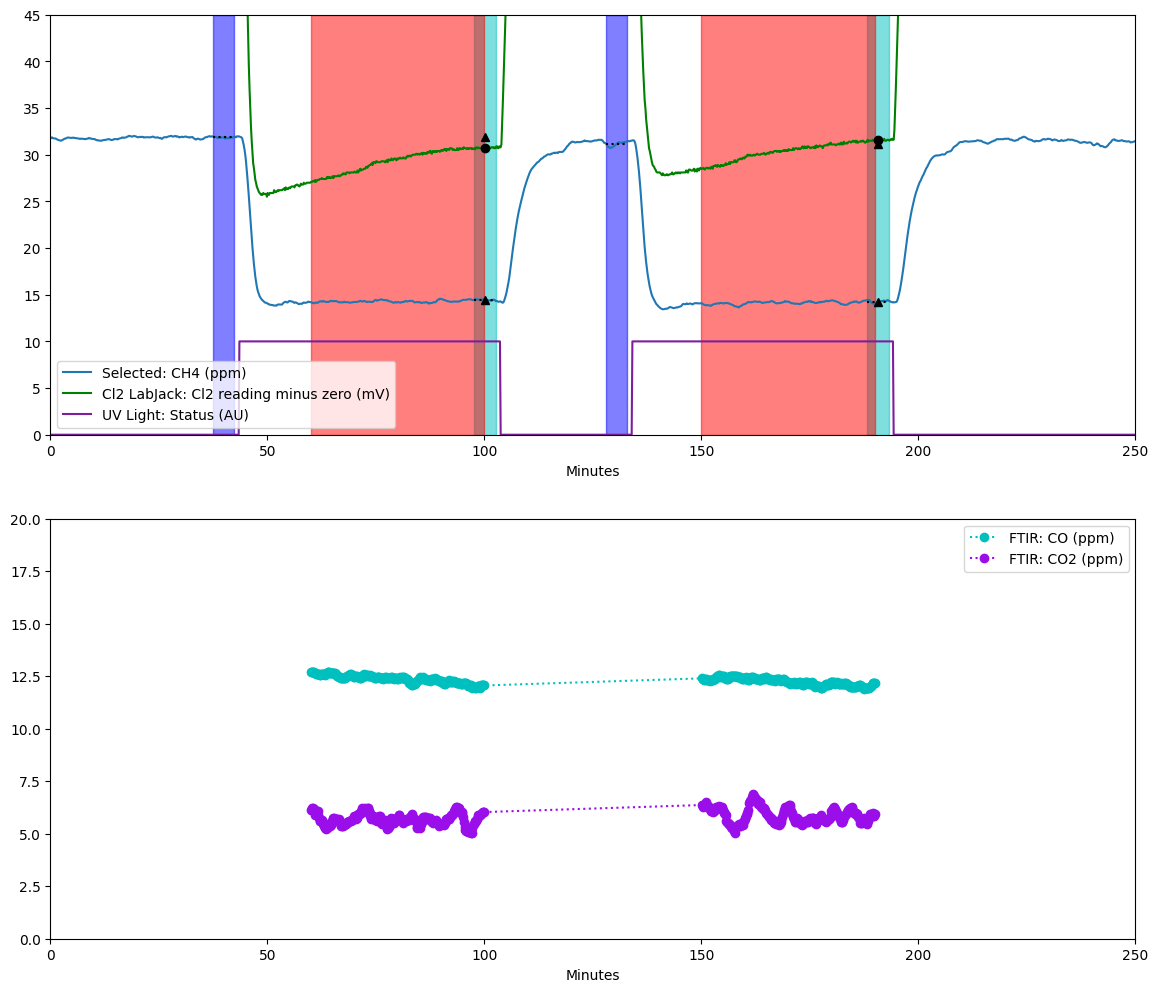

In [3]:
importlib.reload(process_cl2)
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-44.1)

current_experiment = '01-16-25 Base Case'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=2,figsize=(14,12),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.bypass_intervals[current_experiment] = [(60, 100), (150, 190)] #rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=1150,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=1150,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,250)
axs[0].set_ylim(0,45)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,20)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")


pass

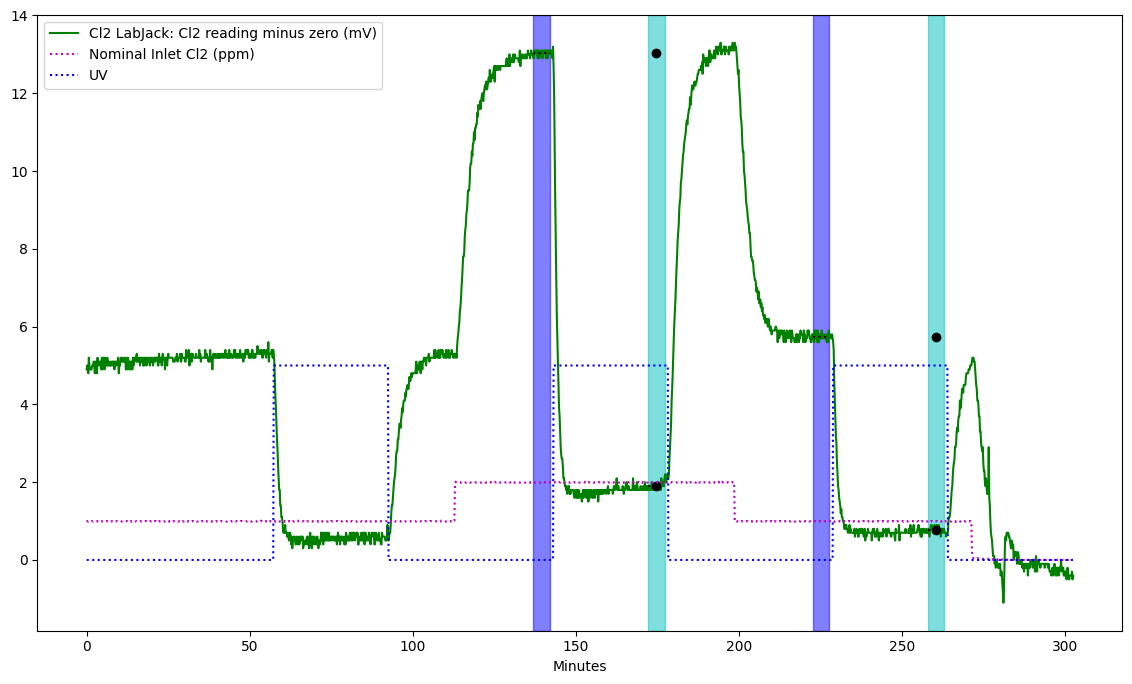

In [4]:
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-43.0)

importlib.reload(process_cl2)
current_experiment = '01-30-25 Radical Count 1-2ppm P2'
rf.dump_experiment(current_experiment)

data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=1,figsize=(14,8),sharex=True)
axs = [axs]

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the Cl2
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=100,end_time=500,correct_drift=False)
#rf.manual_find_removal(current_experiment,sample_times=[200],baseline_times=[170])
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[0],do_shading=True)
axs[0].legend()

axs[0].set_xlabel("Minutes")
axs[0].plot(data[current_experiment]['Minutes'],(20.0/200.0)*data[current_experiment]['Cl2 MFC: Actual Flow'],'m:',label='Nominal Inlet Cl2 (ppm)')
axs[0].plot(data[current_experiment]['Minutes'],5*data[current_experiment]['UV Light: Actual Status'],'b:',label='UV')
axs[0].legend()

#axs[0].plot([0,450],[40.8,40.8],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!
pass


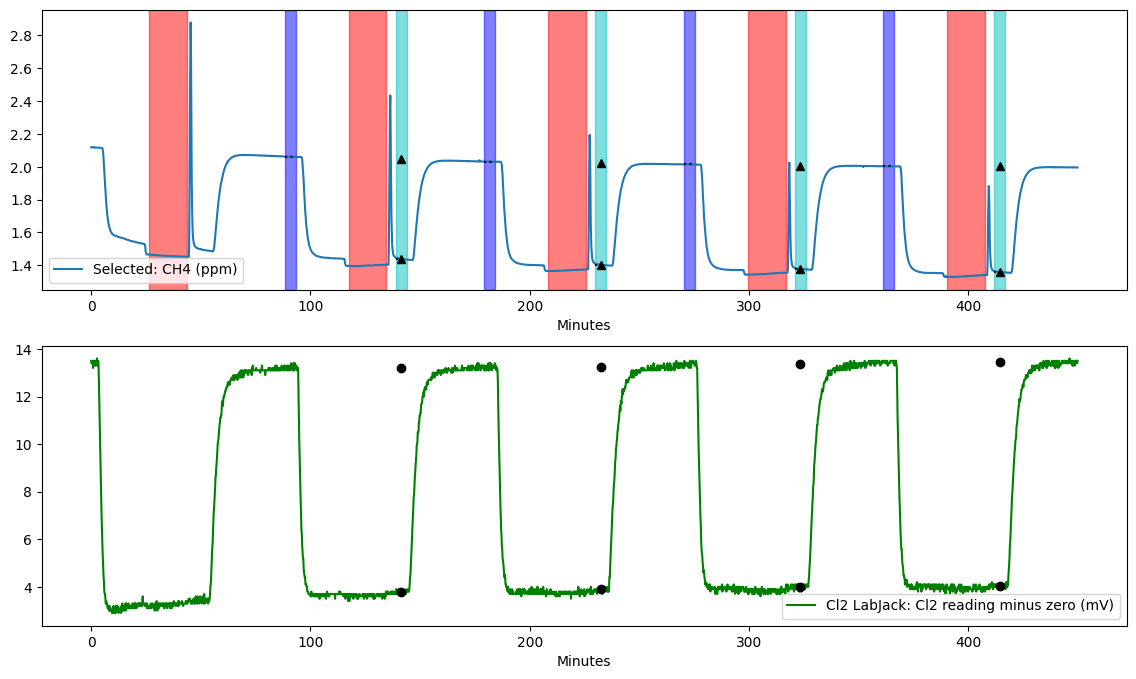

In [5]:
importlib.reload(process_cl2)
current_experiment = '01-31-25 Realistic AMR'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['Picarro: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=2,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[1],do_shading=False)
#axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet',label='CO2')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
#axs[0].set_xlim(0,370)

#axs[1].set_ylim(0,40)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

pass


In [6]:
rf.export_conversion_results_to_csv('../_exported_data/')
rf.export_bypass_periods('../_exported_data/')